基础_模型迁移_CBIR_augmentation  
by jsxyhelu  
注意，本模型最好不要在GPU下执行  

In [1]:
import numpy as np
import cv2
import os
import math
import h5py as h5py 

In [2]:
#!apt-get -qq install -y graphviz && pip install -q pydot

In [3]:
import pydot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image

Using TensorFlow backend.


In [4]:
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [6]:
#训练集和验证集比率
RATIO = 0.2
#根据分类总数确定one-hot总类
NUM_DENSE = 5
#训练总数。经过实验发现epoch = 7 的时候，模型收敛，准确率98
#TODOepochs = 7
epochs = 1
#默认图片大小:48*48
ishape=48

In [7]:
#one hot TODO给改掉
def tran_y(y): 
    y_ohe = np.zeros(NUM_DENSE) 
    y_ohe[y] = 1 
    return y_ohe

In [22]:
#导入vgg模型
model_vgg = VGG16(include_top =False,
                  weights = 'imagenet',
                  input_shape = (ishape,ishape, 3)) 

TypeError: TF_SessionRun_wrapper: expected all values in input dict to be ndarray

In [8]:

#将fc层失活，并且重新迁移训练
for layer in model_vgg.layers:
        layer.trainable = False
model = Flatten()(model_vgg.output) 
model = Dense(4096, activation='relu', name='fc1')(model)
model = Dense(4096, activation='relu', name='fc2')(model)
model = Dropout(0.5)(model)
model = Dense(NUM_DENSE, activation = 'softmax', name='prediction')(model) 
model_vgg_pretrain = Model(model_vgg.input, model, name = 'vgg16_pretrain')

#模型编译
sgd = SGD(lr = 0.05, decay = 1e-5) 
model_vgg_pretrain.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


TypeError: TF_SessionRun_wrapper: expected all values in input dict to be ndarray

In [ ]:
#模型结构打印
plot_model(model_vgg_pretrain, to_file="model.png", show_shapes=True)
Image('model.png')

In [ ]:
#print('下载数据')
#下载已经打包好的数据集,本例先验3**汽车、4**恐龙、5**大象、6**花、7**马
path='littleCBIR_none.npz'
path = get_file(path,origin='https://github.com/jsxyhelu/DateSets/raw/master/littleCBIR_none.npz')
f = np.load(path)
X_train, y_train = f['X_train'], f['y_train']
X_test, y_test = f['X_test'], f['y_test']

In [ ]:
#下载的图片进行格式转换
X_train = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in X_train] 
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32') 
X_train /= 255.0

X_test = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in X_test] 
X_test = np.concatenate([arr[np.newaxis] for arr in X_test]).astype('float32')
X_test /= 255.0

y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))]) 
y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])
y_train_ohe = y_train_ohe.astype('float32')
y_test_ohe = y_test_ohe.astype('float32')

In [ ]:
#agumentation
# 设置生成参数
img_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
#print('模型训练')
#模型训练
#TODOsteps_per_epoch = 400
img_generator.fit(X_train)
log = model_vgg_pretrain.fit_generator(img_generator.flow(X_train,y_train_ohe, batch_size= 128), steps_per_epoch = 10, epochs=epochs,validation_data=(X_test, y_test_ohe),workers=4)
score = model_vgg_pretrain.evaluate(X_test, y_test_ohe, verbose=0)

In [ ]:
#打印显示结果
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#绘制loss和acc曲线
plt.figure('acc')  
plt.subplot(2, 1, 1)  
plt.plot(log.history['acc'],'r--',label='Training Accuracy')  
plt.plot(log.history['val_acc'],'r-',label='Validation Accuracy')  
plt.legend(loc='best')  
plt.xlabel('Epochs')  
plt.axis([0, epochs, 0.9, 1])  
plt.figure('loss')  
plt.subplot(2, 1, 2)  
plt.plot(log.history['loss'],'b--',label='Training Loss')  
plt.plot(log.history['val_loss'],'b-',label='Validation Loss')  
plt.legend(loc='best')  
plt.xlabel('Epochs')  
plt.axis([0, epochs, 0, 1])  
plt.show() 

下载数据
模型训练
Epoch 1/1
10/10 [==============================] - 31s 3s/step - loss: 1.3549 - acc: 0.4646 - val_loss: 0.9262 - val_acc: 0.7600
Test loss: 0.9261588191986084
Test accuracy: 0.76


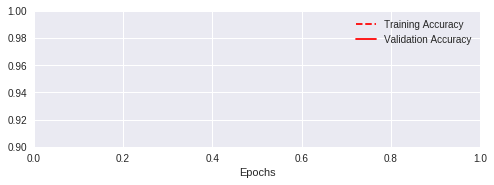

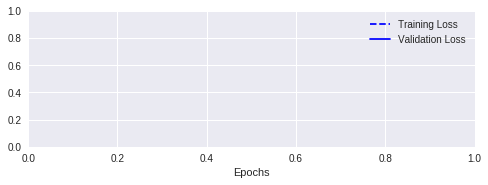

In [24]:
model_vgg_pretrain.save('5type4cbirMODEL.h5')

In [25]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile()
uploaded.SetContentFile('5type4cbirMODEL.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))



Uploaded file with ID 1qjxAm_QiXdSqBmyIoPl3bfnyLNJxwKo9


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#根据文件名进行下载
file_id = '1qjxAm_QiXdSqBmyIoPl3bfnyLNJxwKo9'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))